In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [4]:
import honk_sv.train as hk
from honk_sv import model as mod
from honk_sv import dataset as dset
from honk_sv import system as svs
from honk_sv import dataloader as dloader

# Dataframes
command: disjoint speaker split

In [3]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/'
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Reddots_Dataframe.pkl')

### Dataset split

In [5]:
#TODO: correct splits
all_spks = data_df.spk.unique()
all_sents = data_df.sent.unique()
uttrs_counts = data_df.spk.value_counts()
sv_spks = list(uttrs_counts.index[-9:])
si_spks = list(uttrs_counts.index[:-9])

# SI Train

In [6]:
import random 

si_df = data_df[data_df.spk.isin(si_spks)]

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[random] train:12071, val:1509, test:1509


In [7]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_random_train, 'val':si_random_val, 'test':si_random_test}
manifest_dir = "manifests/reddots/"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("reddots", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = si_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/reddots/si_reddots_train_manifest.csv was written
manifests/reddots/si_reddots_val_manifest.csv was written
manifests/reddots/si_reddots_test_manifest.csv was written


In [72]:
model = "res8"
dataset = "reddots"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0,
                     n_epochs=100, batch_size=64,
                     lr=[0.01], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001,
                     num_workers=16, print_step=100,
                     splice_length=20
                     )

builder = hk.ConfigBuilder(
                mod.find_config(model),
                dset.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

si_config['n_labels'] = len(si_spks)
si_config['input_length'] = int(16000*1)
manifest_dir = "manifests/reddots/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)]=os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("reddots", tag))

In [51]:
si_model = si_config['model_class'](si_config)

In [67]:
from torch.autograd import Variable
import torch
import torch.nn as nn

si_config['model_class'] = mod.SimpleCNN
si_model = mod.SimpleCNN()
test_in = Variable(torch.zeros(1,1,20,40), volatile=True)
test_out = si_model(test_in)
si_model.feat_size = test_out.size(1)
si_model.output = nn.Linear(test_out.size(1), si_config["n_labels"])

In [68]:
# si_model.load("models/reddots/si_reddots_frames_res8.pt")
si_config['n_epochs'] = 100
si_config['output_file'] = "models/reddots/si_reddots_frames_fewshot.pt"
hk.train(si_config, model=si_model, _collate_fn=dloader._random_frames_collate_fn)

train step #99 accuracy: 0.1875, loss: 3.177502393722534


Process Process-3553:
KeyboardInterrupt
Process Process-3554:
Process Process-3566:
Process Process-3559:
Process Process-3556:
Process Process-3558:


KeyboardInterrupt: 

Process Process-3564:
Process Process-3565:
Process Process-3561:
Process Process-3555:
Process Process-3557:
Process Process-3562:
Process Process-3560:
Process Process-3563:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    se

  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 341, in get
    with self._rlock:
  File "/home/muncok/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return sel

# SV Enrollment & Test

In [28]:
import random
random.shuffle(sv_spks)
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]

In [29]:
enroll_spks

['m0045', 'm0056', 'f0015', 'f0003', 'm0063']

In [30]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

sv_df = data_df[(data_df.spk.isin(sv_spks))]
# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(n=1)
    devs = spk_df.drop(index=enls.index)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)]

In [29]:
# dev_uttrs.to_pickle("./dev_uttrs.pkl")
# test_uttrs.to_pickle("./test_uttrs.pkl")

# dev_uttrs = pd.read_pickle("./dev_uttrs.pkl")
# test_uttrs = pd.read_pickle("./test_uttrs.pkl")
# enroll_spks = list(dev_uttrs.spk.unique())

In [31]:
import csv
import random

manifest_dir = "./manifests/reddots/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("reddots", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/reddots/enroll/enroll_reddots_m0045_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_m0056_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_f0015_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_f0003_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_m0063_manifest.csv was written


In [32]:
si_config['input_length'] = int(16000*4)
si_model.load("models/reddots/si_reddots_frames_res8.pt")

AttributeError: 'Sequential' object has no attribute 'load'

In [69]:
# enrolling speakers
# generating speaker models
si_config['batch_size'] = 1
manifest_dir = "./manifests/reddots/enroll/"
spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("reddots", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = svs.enroll_frame(si_config, model=si_model,_collate_fn=dloader._nooverlap_frames_collate_fn)

In [70]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

m0045, m0056: 0.92
m0045, f0015: 0.75
m0045, f0003: 0.77
m0045, m0063: 0.91
m0056, f0015: 0.83
m0056, f0003: 0.60
m0056, m0063: 0.87
f0015, f0003: 0.42
f0015, m0063: 0.82
f0003, m0063: 0.58


In [40]:
def pairwise_cosine(spk_model, test_in):
    nb_enroll_spks = len(spk_models.keys())
    scores = np.zeros(nb_enroll_spks)
    for i in range(nb_enroll_spks):
        signature = spk_model[i]
        scores[i] = 1-cosine(test_in, signature)
    return scores

In [41]:
spk_model = [v for k,v in spk_models.items()]

In [44]:
corrects = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    pred_spk = np.argmax(pairwise_cosine(spk_model, emb))
    label = enroll_spks.index(row.spk)
#     if pred_spk == label:
#         corrects += 1

print("SI Acc: {}".format(corrects/ len(dev_uttrs)))

SI Acc: 0.0


In [91]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    i+=1

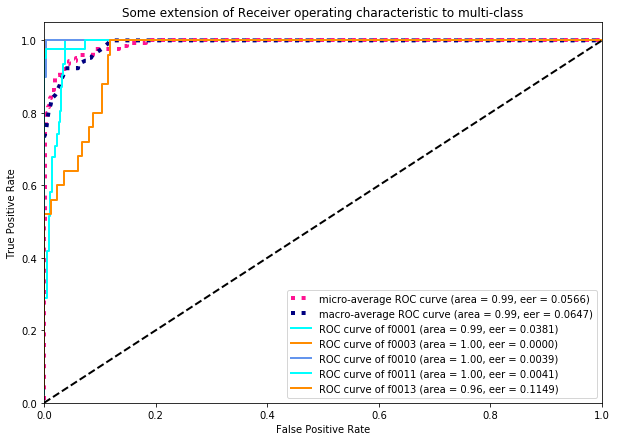

In [92]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [83]:
len(dev_uttrs)

125

## SV Test with Voxc

In [37]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/voxceleb/'
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Voxc_Dataframe.pkl')

In [39]:
all_spks = list(data_df.spk.unique())

In [40]:
enroll_spks = random.choices(all_spks, k=3)

In [43]:
test_spks = random.choices(all_spks, k=10)

In [44]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

sv_df = data_df
# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(n=10)
    devs = spk_df.drop(index=enls.index).sample(n=20)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])
    
test_uttrs = sv_df[sv_df.spk.isin(test_spks)].sample(n=2*len(dev_uttrs))

In [18]:
# dev_uttrs.to_pickle("./dev_uttrs.pkl")
# test_uttrs.to_pickle("./test_uttrs.pkl")

# dev_uttrs = pd.read_pickle("./dev_uttrs.pkl")
# test_uttrs = pd.read_pickle("./test_uttrs.pkl")
# enroll_spks = list(dev_uttrs.spk.unique())

In [47]:
import csv
import random

manifest_dir = "./manifests/reddots/enroll/"
# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        

for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("reddots", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.spk, row.file)
            label = enroll_spks.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/reddots/enroll/enroll_reddots_Isla_Fisher_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_Ryan_Kwanten_manifest.csv was written
./manifests/reddots/enroll/enroll_reddots_Jean-Paul_Belmondo_manifest.csv was written


In [61]:
si_config['input_length'] = int(16000*4)

In [51]:
si_model.load("models/reddots/si_reddots_frames_res8.pt")

In [62]:
# enrolling speakers
# generating speaker models
si_config['batch_size'] = 1
manifest_dir = "./manifests/reddots/enroll/"
spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("reddots", spk))
    si_config['test_manifest'] =  manifest_path
    spk_models[spk] = svs.enroll_frame(si_config, model=si_model,test_loader=None)

In [63]:
from scipy.spatial.distance import cosine
import itertools

for spk1, spk2 in itertools.combinations(enroll_spks,2):
    score = 1-cosine(spk_models[spk1], spk_models[spk2])
    print("{}, {}: {:.2f}".format(spk1, spk2, score))

Isla_Fisher, Ryan_Kwanten: -0.14
Isla_Fisher, Jean-Paul_Belmondo: -0.27
Ryan_Kwanten, Jean-Paul_Belmondo: 0.85


In [64]:
def pairwise_cosine(spk_model, test_in):
    nb_enroll_spks = len(spk_models.keys())
    scores = np.zeros(nb_enroll_spks)
    for i in range(nb_enroll_spks):
        signature = spk_model[i]
        scores[i] = 1-cosine(test_in, signature)
    return scores

In [65]:
spk_model = [v for k,v in spk_models.items()]

In [66]:
corrects = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.embed(si_config, si_model, audio_path)
    pred_spk = np.argmax(pairwise_cosine(spk_model, emb))
    label = enroll_spks.index(row.spk)
    if pred_spk == label:
        corrects += 1

print("SI Acc: {}".format(corrects/ len(dev_uttrs)))

SI Acc: 0.7333333333333333


In [67]:
nb_total_uttrs = len(dev_uttrs)+len(test_uttrs)
n_classes = len(enroll_spks)
score_vector = np.zeros((nb_total_uttrs, n_classes))
label_vector = np.zeros((nb_total_uttrs, n_classes))

spk_model = [v for k,v in spk_models.items()]
spk_labels = list(spk_models.keys())

i = 0
for idx, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    label = spk_labels.index(row.spk)
    label_vector[i, label] = 1
    i+=1

for idx, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.spk, row.file)
    emb = svs.dvector(si_config, si_model, audio_path)
    score_vector[i, :] = pairwise_cosine(spk_model, emb)
    i+=1

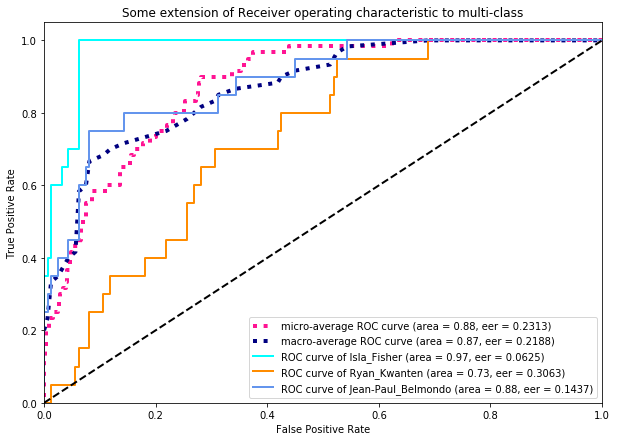

In [68]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(10,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.4f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f}, eer = {2:0.4f})'
             ''.format(spk_labels[i], roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()